In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
torch.__version__

'1.13.1'

# device cuda 확인

In [320]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# data를 tensor 로 받기

In [321]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

# x, y split

In [322]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

# get model

In [323]:
# Subclass nn.Module to make our model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModel()
model_1, model_1.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

# 모델의 device 확인 및 교체

In [324]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [325]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

# Training 파트에 필요한 것

- Loss Function 
- Optimizer
- Training loop
- Testing loop

In [326]:
loss_fn = nn.L1Loss() # MAE 와 같음

optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.01)

In [327]:
torch.manual_seed(42)

# 시각화 용
train_loss_values = []
test_loss_values = []
epoch_count = []

# 학습 주기 설정
epochs = 100 

# device 설정 맞춰주기
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

        if epoch % 10 == 0:
              epoch_count.append(epoch)
              train_loss_values.append(loss.cpu().numpy())
              test_loss_values.append(test_loss.cpu().numpy())
              print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.5551779866218567 | MAE Test Loss: 0.5739762187004089 
Epoch: 10 | MAE Train Loss: 0.439968079328537 | MAE Test Loss: 0.4392664134502411 
Epoch: 20 | MAE Train Loss: 0.3247582018375397 | MAE Test Loss: 0.30455657839775085 
Epoch: 30 | MAE Train Loss: 0.20954833924770355 | MAE Test Loss: 0.16984669864177704 
Epoch: 40 | MAE Train Loss: 0.09433845430612564 | MAE Test Loss: 0.03513690456748009 
Epoch: 50 | MAE Train Loss: 0.023886388167738914 | MAE Test Loss: 0.04784907028079033 
Epoch: 60 | MAE Train Loss: 0.019956795498728752 | MAE Test Loss: 0.045803118497133255 
Epoch: 70 | MAE Train Loss: 0.016517987474799156 | MAE Test Loss: 0.037530567497015 
Epoch: 80 | MAE Train Loss: 0.013089174404740334 | MAE Test Loss: 0.02994490973651409 
Epoch: 90 | MAE Train Loss: 0.009653178043663502 | MAE Test Loss: 0.02167237363755703 


In [328]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

# weight 와 bias 출력

In [329]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6691]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3130], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# 평가 모드 전환 및 y_preds 값 얻기

In [330]:
# model을 evaluation 모드로 변경
model_1.eval()

# x test 데이터를 가지고 예측하기
with torch.inference_mode():
    y_preds = model_1(X_test)

y_preds

tensor([[0.8483],
        [0.8617],
        [0.8750],
        [0.8884],
        [0.9018],
        [0.9152],
        [0.9286],
        [0.9420],
        [0.9553],
        [0.9687]], device='cuda:0')

In [331]:
y_preds.device

device(type='cuda', index=0)

# y_preds 값을 실제 값과 시각화하여 비교

In [332]:
# 시각화를 위해 device 를 cpu 로 고치기
y_preds_cpu = y_preds.to('cpu')
X_train_cpu = X_train.to('cpu')
X_test_cpu = X_test.to('cpu')
y_train_cpu = y_train.to('cpu')
y_test_cpu = y_test.to('cpu')

In [333]:
X_train.device, X_test.device, y_train.device, y_test.device, y_preds.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [334]:
X_train_cpu.device, X_test_cpu.device, y_train_cpu.device, y_test_cpu.device, y_preds_cpu.device

(device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'))

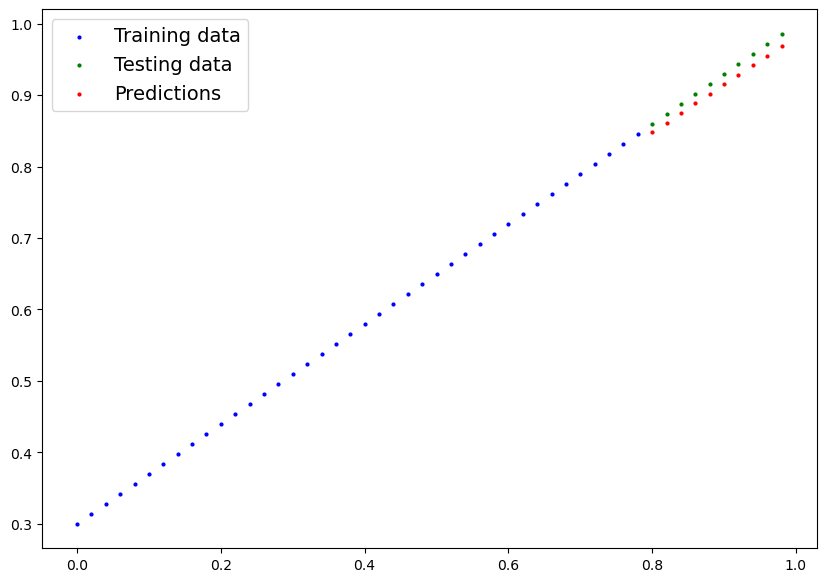

In [335]:
# 예측한 선형 모델을 실제 값과 비교
plot_predictions(
                train_data= X_train_cpu,
                train_labels= y_train_cpu,
                test_data= X_test_cpu,
                test_labels= y_test_cpu,
                predictions=y_preds_cpu
                )

# epoch 마다 loss 변화모습 시각화

In [336]:
epoch_count, train_loss_values, test_loss_values

([0, 10, 20, 30, 40, 50, 60, 70, 80, 90],
 [array(0.555178, dtype=float32),
  array(0.43996808, dtype=float32),
  array(0.3247582, dtype=float32),
  array(0.20954834, dtype=float32),
  array(0.09433845, dtype=float32),
  array(0.02388639, dtype=float32),
  array(0.0199568, dtype=float32),
  array(0.01651799, dtype=float32),
  array(0.01308917, dtype=float32),
  array(0.00965318, dtype=float32)],
 [array(0.5739762, dtype=float32),
  array(0.4392664, dtype=float32),
  array(0.30455658, dtype=float32),
  array(0.1698467, dtype=float32),
  array(0.0351369, dtype=float32),
  array(0.04784907, dtype=float32),
  array(0.04580312, dtype=float32),
  array(0.03753057, dtype=float32),
  array(0.02994491, dtype=float32),
  array(0.02167237, dtype=float32)])

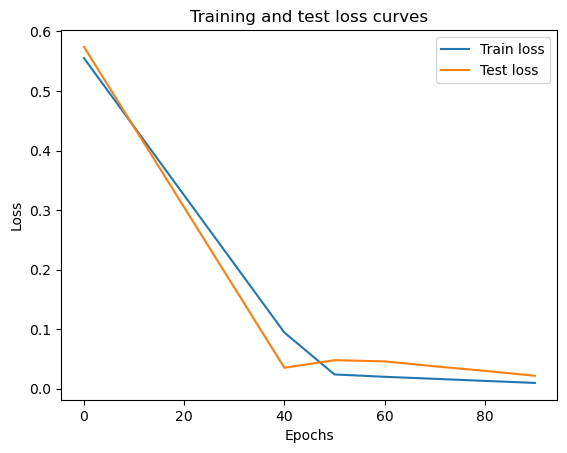

In [337]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [338]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
 
# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\01_pytorch_workflow_model_1.pth


In [339]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

'ls'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


# state_dict 불러오고, 기존 모델에 적용

In [340]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_1 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_1.to(device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [341]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6691]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3130], device='cuda:0'))])

In [342]:
# 기존 모델과 불러왔던 모델 비교
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')